# Assignment 2 (67 marks total)
### Due: April 10, 2024, at 11:59pm

Global rules: you are allowed to add as many code and markdown cells as you would like (and you probably should add some). Your are allowed to use `scikit-learn` _only_ for the purposes of generating datasets. In particular, the function `sklearn.datasets.make_blobs` will likely be useful. You should not use `scikit-learn` or any other machine learning library for any other purpose. There should be enough comments and markdown cells explaining code that it is easy for a reader to understand your code and its outputs.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

np.random.seed(42)

In [2]:
#will only work if you have sklearn installed
from sklearn.datasets import make_blobs

## Part 1 - Clustering (44 marks total)

First, implement three clustering algorithms: agglomerative clustering, k-means, and fuzzy c-means (plus defuzzification). You should include some automated function to find the optimal number of clusters using the Davies-Bouldin statistic, as you will need it later.

Then, generate some 2-dimensional datasets to test your implementations on. Evaluate your implementations visually, using the Davies-Bouldin statistic, and by measuring their running time (including the automated search for the best number of clusters).

- 5 marks for implementing Davies-Bouldin score
- 11 marks for implementing agglomerative clustering
- 9 marks for implementing k-means
- 12 marks for implementing fuzzy c-means
- 7 marks for evaluation

In [3]:
rng = np.random.RandomState(1)

#Davies-Bouldin Statistic
def davies_bouldin(X, labels):
    unique_labels = np.unique(labels).astype(int)
    if(len(unique_labels) == 1):
        return np.nan
    centroids = np.array([np.mean(X[labels == i], axis = 0) for i in unique_labels])
    centroid_distances = np.array([[np.linalg.norm(c1 - c2) for c1 in centroids] for c2 in centroids])
    cluster_scatter = np.array([np.mean(np.sqrt(np.sum((X[labels == i] - centroids[unique_labels == i])**2, axis=1))) for i in unique_labels])
    db_scores = np.array([np.max([(cluster_scatter[unique_labels == i] + cluster_scatter[unique_labels == j])/(centroid_distances[unique_labels == i, unique_labels == j]) for j in np.delete(unique_labels, unique_labels==i)]) for i in unique_labels])
    return np.mean(db_scores)

def agglomerative(X, min_clusters, max_clusters):
    C = np.arange(X.shape[0])[:, np.newaxis].tolist()
    labels = np.empty((X.shape[0], X.shape[0]))
    db_scores = np.empty(X.shape[0])

    for i in range(X.shape[0] - 2):
        C = merge_clusters(X, C)
        if(i > X.shape[0] - max_clusters and i < X.shape[0] - min_clusters):
            labels[i] = get_labels(X, C)
            db_scores[i] = davies_bouldin(X, labels[i])

    db_scores = db_scores[-max_clusters+1:-min_clusters]
    labels = labels[-max_clusters+1:-min_clusters]
    return labels[np.argmin(db_scores)]

def merge_clusters(X, C):
    dis_mat = np.array([[dis(X[c1], X[c2]) for c1 in C] for c2 in C])
    np.fill_diagonal(dis_mat, np.nan)
    c1_index, c2_index = np.unravel_index(np.nanargmin(dis_mat), dis_mat.shape)
    newCluster = np.concatenate((C[c1_index], C[c2_index])).tolist()
    C.pop(c1_index)
    if(c1_index < c2_index):
        C.pop(c2_index - 1)
    else:
        C.pop(c2_index)
    C.append(newCluster)
    return C

def get_labels(X, C):
    #make array of labels from cluster indices
    labels = np.empty(X.shape[0])
    for i in range(len(C)):
        labels[C[i]] = i
    return labels

def dis(X1, X2):
    dissimilarity = np.linalg.norm(X1[0]-X2[0])
    for x1 in X1:
        for x2 in X2:
            min = np.min([dissimilarity, np.linalg.norm(x1-x2)])
    return dissimilarity

def k_means(X, min_K, max_K, max_iterations):
    num_k = max_K - min_K + 1
    labels = np.empty((num_k, X.shape[0]))
    db_scores = np.empty((num_k))
    for k in range(num_k):
        reps = rng.rand(k + min_K, X.shape[1]) * (np.max(X) - np.min(X)) + np.min(X)
        labels[k] = np.array([nearest_rep(x, reps) for x in X])
    
        for t in range(max_iterations):
            reps = [np.mean(X[labels[k] == i], axis = 0) for i in range(len(reps))]
    
            #handle empty clusters
            most_assigned_cluster = np.argmax([len(X[labels[k] == i]) for i in range(len(reps))])
            for i in range(len(reps)):
                if(X[labels[k] == i].shape[0] == 0):
                    reps[i] = reps[most_assigned_cluster]
            
            old_labels = np.copy(labels[k])
            labels[k] = np.array([nearest_rep(x, reps) for x in X])
            if(np.all(labels[k] == old_labels)):
                break
        db_scores[k] = davies_bouldin(X, labels[k])
    return labels[np.nanargmin(db_scores)]

def nearest_rep(x, reps):
    return np.nanargmin([np.linalg.norm(rep - x) for rep in reps])

def fuzzy_c_means(X, min_K, max_K, max_iterations, q, epsilon):
    num_k = max_K - min_K + 1
    labels = np.empty((num_k, X.shape[0]))
    db_scores = np.empty((num_k))
    for k in range(num_k):
        centroids = rng.rand(k + min_K, X.shape[1]) * (np.max(X) - np.min(X)) + np.min(X)
        partition = c_means_partition(X, centroids, q)
    
        for t in range(max_iterations):
            centroids = np.array([np.sum([partition[i, j] * X[i] for i in range(X.shape[0])], axis = 0)/np.sum([partition[i, j] for i in range(X.shape[0])], axis = 0) for j in range(centroids.shape[0])])
            
            old_partition = np.copy(partition)
            partition = c_means_partition(X, centroids, q)
            
            if(np.max([[partition[i, j] - old_partition[i, j] for j in range(centroids.shape[0])] for i in range(X.shape[0])]) <= epsilon):
                break
        
        labels[k] = defuzzify(partition)
        db_scores[k] = davies_bouldin(X, labels[k])
    return labels[np.nanargmin(db_scores)]

def c_means_partition(X, centroids, q):
    return np.array([[1/np.sum([(np.linalg.norm(x - centroids[j])/np.linalg.norm(x - centroids[c]))**(2/(q - 1)) for c in range(centroids.shape[0])]) for j in range(centroids.shape[0])] for x in X])

def defuzzify(partition):
    return [np.argmax(p) for p in partition]

Agglomerative average time: 2.7819570004940033 seconds with average davies bouldin score: 0.36408082875581704
K-means average time: 0.14559927582740784 seconds with average davies bouldin score: 0.3616489058029787
Fuzzy C-means average time: 2.0864513218402863 seconds with average davies bouldin score: 0.3595295254138433


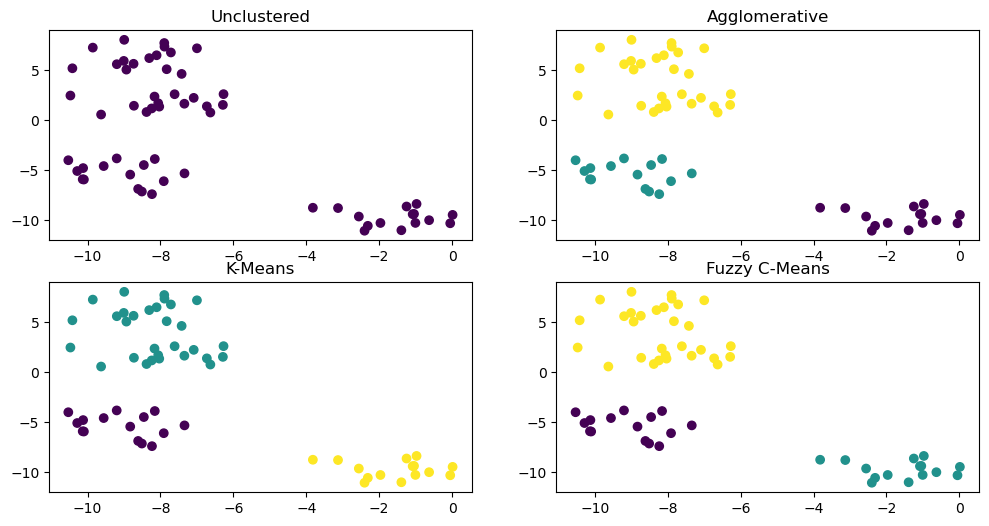

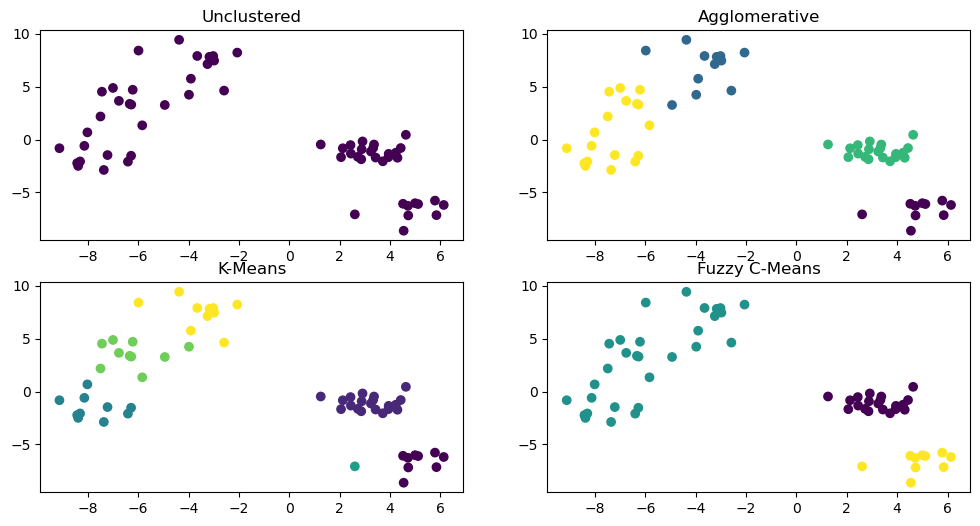

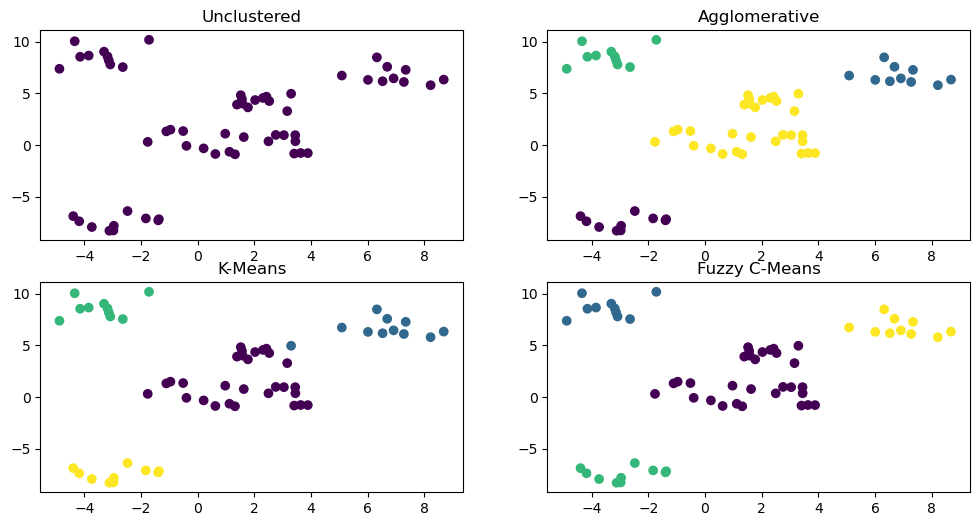

In [10]:
import time
rng = np.random.RandomState(3)

min_K, max_K = 2, 12
agg_times = []
k_means_times = []
fcm_times = []
agg_db_scores = []
k_means_db_scores = []
fcm_db_scores = []

for i in range(3):
    num_centers = rng.randint(low=2, high=8)
    X, Y = make_blobs(n_samples=60, n_features=2, centers=num_centers, random_state=rng)
    
    fig, axs = plt.subplots(2, 2, figsize=(12, 6))
    axs[0, 0].set_title("Unclustered")
    axs[0, 0].scatter(X[:, 0], X[:, 1], c=np.ones(X.shape[0]))

    start_time = time.time()
    labels = agglomerative(X, min_K, max_K)
    end_time = time.time()
    agg_times.append(end_time - start_time)
    agg_db_scores.append(davies_bouldin(X, labels))
    
    axs[0, 1].set_title("Agglomerative")
    axs[0, 1].scatter(X[:, 0],X[:, 1], c=labels)
    
    start_time = time.time()
    labels = k_means(X, min_K, max_K, 20)
    end_time = time.time()
    k_means_times.append(end_time - start_time)
    k_means_db_scores.append(davies_bouldin(X, labels))
    
    axs[1, 0].set_title("K-Means")
    axs[1, 0].scatter(X[:, 0],X[:, 1], c=labels)
    
    start_time = time.time()
    labels = fuzzy_c_means(X, min_K, max_K, 20, 1.2, 0.2)
    end_time = time.time()
    fcm_times.append(end_time - start_time)
    fcm_db_scores.append(davies_bouldin(X, labels))
    
    axs[1, 1].set_title("Fuzzy C-Means")
    axs[1, 1].scatter(X[:, 0],X[:, 1], c=labels)

for i in range(5):
    num_centers = rng.randint(low=2, high=8)
    X, Y = make_blobs(n_samples=60, n_features=2, centers=num_centers, random_state=rng)
    
    start_time = time.time()
    labels = agglomerative(X, min_K, max_K)
    end_time = time.time()
    agg_times.append(end_time - start_time)
    agg_db_scores.append(davies_bouldin(X, labels))
    
    start_time = time.time()
    labels = k_means(X, min_K, max_K, 20)
    end_time = time.time()
    k_means_times.append(end_time - start_time)
    k_means_db_scores.append(davies_bouldin(X, labels))
    
    start_time = time.time()
    labels = fuzzy_c_means(X, min_K, max_K, 20, 1.2, 0.3)
    end_time = time.time()
    fcm_times.append(end_time - start_time)
    fcm_db_scores.append(davies_bouldin(X, labels))

print(f"Agglomerative average time: {np.mean(agg_times)} seconds with average davies bouldin score: {np.mean(agg_db_scores)}")
print(f"K-means average time: {np.mean(k_means_times)} seconds with average davies bouldin score: {np.mean(k_means_db_scores)}")
print(f"Fuzzy C-means average time: {np.mean(fcm_times)} seconds with average davies bouldin score: {np.mean(fcm_db_scores)}")


## Part 2 - Linear Classification (19 marks total)

In this part, you will implement binary linear classification using linear regression in two ways: first, assigning the classes to be -1 and +1 and using linear regression as normal, and second, using logistic regression. You should use your preferred implementation of linear regression from assignment 1 (or the assignment 1 sample solutions, if you prefer) for this. Recall that, for logistic regression, you need to use the cross-entropy error and gradient descent.

Generate some 2D datasets to test your implementations on, using separate training and testing sets. Evaluate your implementations visually, using the accuracy statistic (as well as any other statistics that you would like), and the training time.

- 2 marks for cross-entropy error
- 3 marks for linear regression as normal
- 4 marks for logistic regression
- 10 marks for testing

In [5]:
def prepend_ones(X):
    n = len(X)
    return np.insert(X, 0, np.ones(n), axis=1)

#error functions
def sse(true, predicted):
    assert(len(true) == len(predicted))

    error = 0
    for i in range(len(true)):
        error = error + ((true[i] - predicted[i]) ** 2)

    return error

def mse(true, predicted):
    return sse(true, predicted) / len(true)

def cross_entropy_error(true, predicted):
    return -np.sum([true[i] * np.log(predicted[i]) + (1 - true[i]) * np.log(1 - predicted[i]) for i in range(len(true))])

def sigmoid(z):
    return 1/(1+np.exp(-z))

#superclass for linear regressors
class LinearRegressor:
   def __init__(self):
      self.weights = None

   def predict(self, X):
      if self.weights is None:
         print("Model is not trained, cannot predict")
         return None
      
      X_ones = prepend_ones(X)
      return X_ones @ self.weights

#SGD linear regressor implementation
class IterativeLinearRegressor(LinearRegressor):
    def __init__(self):
        super().__init__()

    def train(self, X, t, epochs=30, learning_rate = 0.001, initialization='uniform', predict = lambda X, w: X @ w, error_function = mse):
        assert(len(X) == len(t))
        X_ones = prepend_ones(X)
        n, d = X_ones.shape

        #initialize the weights
        if(initialization == 'uniform'):
            self.weights = np.random.uniform(X.min(), X.max(), d)
        elif(initialization == 'normal'):
            self.weights = np.random.normal(size=d)
        elif(initialization == 'zeros'):
            self.weights = np.zeros(d)
        else:
            print("invalid initialization")
            return

        rng = np.random.default_rng()

        errors = np.zeros(epochs)
        for i in range(epochs):
            indices = rng.permutation(n)

            for j in indices:
                e = t[j] - predict(X_ones[j], self.weights)
                self.weights = self.weights + learning_rate * e * X_ones[j]

            error = error_function(t, predict(X_ones, self.weights))
            errors[i] = error

        return errors

In [6]:
class LinearClassifier():
    def __init__(self):
        self.trained = False
        self.linear_regressor = IterativeLinearRegressor()
        
class LinearRegressionClassifier(LinearClassifier):
    def __init__(self):
        super().__init__()
    def train(self, X, t):
        new_t = t.copy()
        new_t[new_t == 0] = -1
        self.trained = True
        return self.linear_regressor.train(X, new_t, epochs = 50, learning_rate = 0.01)
    def predict(self, X):
        if not self.trained:
            print("Model is not trained, cannot predict")
            return None

        y = np.sign(self.linear_regressor.predict(X))
        y[y == -1] = 0
        return y.astype(int)

class LogisticRegressionClassifier(LinearClassifier):
    def __init__(self):
        super().__init__()
    def train(self, X, t):
        self.trained = True
        return self.linear_regressor.train(X, t, epochs = 50, learning_rate = 0.01, predict = lambda X, w: sigmoid(X @ w), error_function = cross_entropy_error)
    def predict(self, X, threshold = 0.5):
        if not self.trained:
            print("Model is not trained, cannot predict")
            return None
        
        return (sigmoid(self.linear_regressor.predict(X)) >= threshold).astype(int)

def confusion_matrix(T, Y):
    confusion_matrix = np.empty((2, 2))
    True_C1 = T[T == 0]
    True_C2 = T[T == 1]

    Predicted_C1 = Y[Y == 0]
    Predicted_C2 = Y[Y == 1]
    
    confusion_matrix[0, 0] = np.min([len(True_C1), len(Predicted_C1)])
    confusion_matrix[0, 1] = np.min([len(True_C1), len(Predicted_C2)])
    confusion_matrix[1, 1] = np.min([len(True_C2), len(Predicted_C2)])
    confusion_matrix[1, 0] = np.min([len(True_C2), len(Predicted_C1)])
    return confusion_matrix

def sensitivity(c):
    return c[0, 0]/(c[0, 0] + c[1, 1])

def precision(c):
    return c[0, 0]/(c[0, 0] + c[1, 0])

def specificity(c):
    return c[1, 1]/(c[1, 1] + c[1, 0])

def accuracy(c):
    return (c[0, 0] + c[1, 1]) / c.size

def FI_score(c):
    return 2*c[0, 0]/(2*c[0, 0] + c[1, 0] + c[0, 1])

def get_scores(c):
    return [sensitivity(c), precision(c), specificity(c), accuracy(c), FI_score(c)]

+--------------------------+---------------+-------------+---------------+------------+------------+----------------------+
| Average Scores           |   Sensitivity |   Precision |   Specificity |   Accuracy |   FI Score |   Training Time (ms) |
+==========================+===============+=============+===============+============+============+======================+
| With Linear Regression   |      0.571659 |    0.505397 |      0.432427 |    10.6667 |   0.547505 |              9.31215 |
+--------------------------+---------------+-------------+---------------+------------+------------+----------------------+
| With Logistic Regression |      0.571659 |    0.505397 |      0.432427 |    10.6667 |   0.547505 |             18.6199  |
+--------------------------+---------------+-------------+---------------+------------+------------+----------------------+


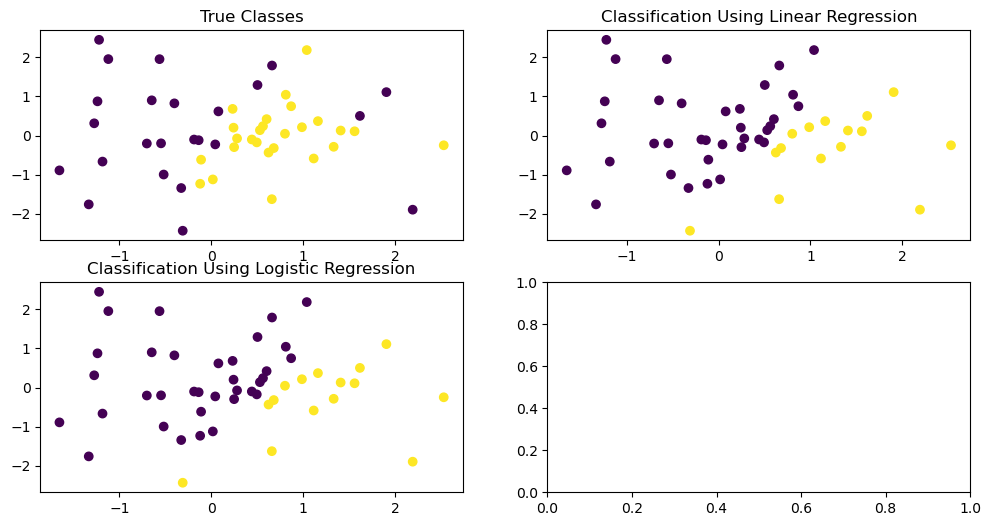

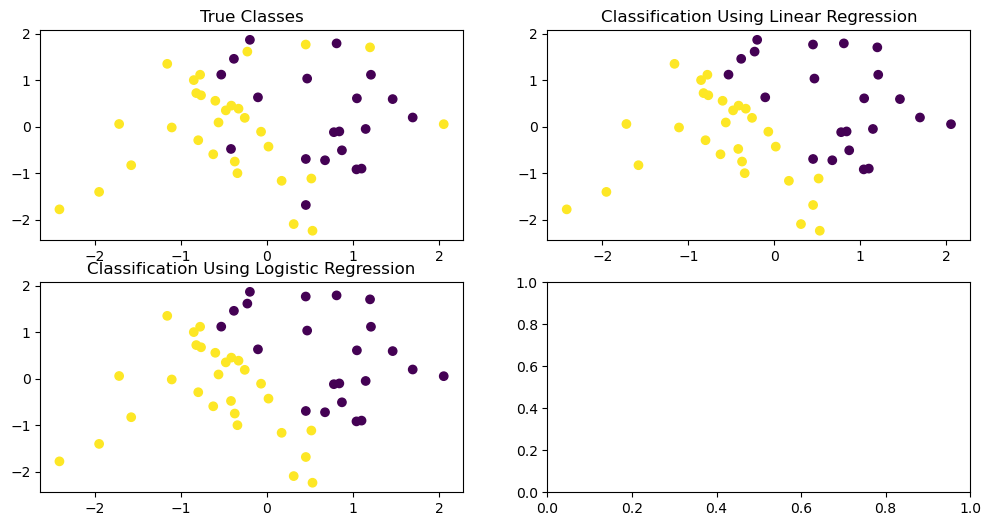

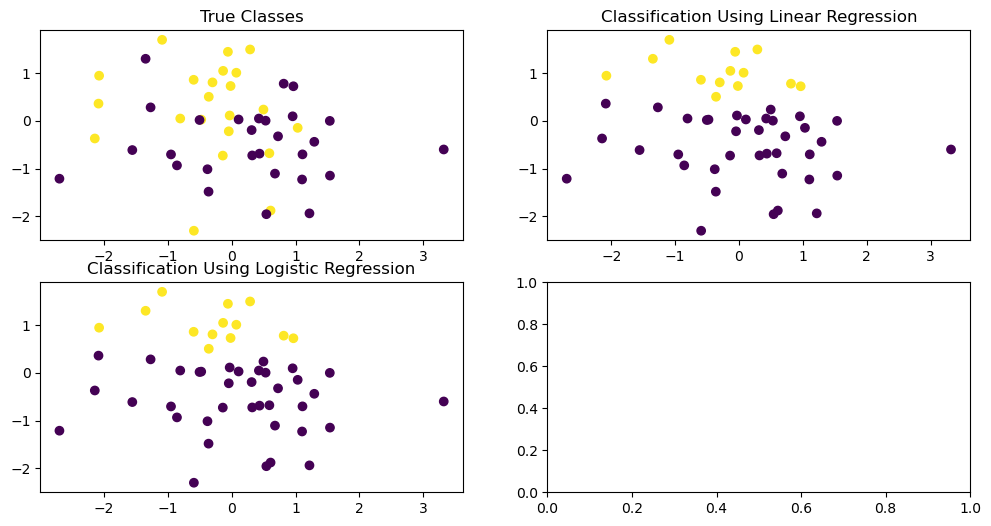

In [11]:
import time
from tabulate import tabulate
rng = np.random.RandomState(1)

def generate_linear_data(n_samples, n_features, w, noise=0.2):
    X = rng.randn(n_samples, n_features)
    y = np.sign(np.dot(X, w))
    
    y_noise = rng.choice([-1, 1], size=n_samples, p=[noise, 1-noise])
    y = y * y_noise
    y[y == -1] = 0
    
    return X, y

n_tests = 3
n_features = 2

lin_reg_scores = np.empty((n_tests, 6))
log_reg_scores = np.empty((n_tests, 6))

for i in range(n_tests):
    w = rng.randn(n_features)
    X, Y = generate_linear_data(50, n_features, w)
    
    linear_reg_classifier = LinearRegressionClassifier()
    logistic_reg_classifier = LogisticRegressionClassifier()
    
    start_time = time.time()
    linear_reg_classifier.train(X, Y)
    end_time = time.time()
    lin_reg_train_time = (end_time - start_time)*1000
    
    start_time = time.time()
    logistic_reg_classifier.train(X, Y)
    end_time = time.time()
    log_reg_train_time = (end_time - start_time)*1000
    
    X, Y = generate_linear_data(50, n_features, w)
    
    fig, axs = plt.subplots(2, 2, figsize=(12, 6))
    axs[0, 0].set_title("True Classes")
    axs[0, 0].scatter(X[:, 0], X[:, 1], c=Y)
    axs[0, 1].set_title("Classification Using Linear Regression")
    
    Y_pred = linear_reg_classifier.predict(X)
    axs[0, 1].scatter(X[:, 0], X[:, 1], c=Y_pred)
    
    c_matrix = confusion_matrix(Y, Y_pred)
    lin_reg_scores[i] = np.concatenate((get_scores(c_matrix), [lin_reg_train_time]))

    axs[1, 0].set_title("Classification Using Logistic Regression")
    
    start_time = time.time()
    y_pred = logistic_reg_classifier.predict(X)
    end_time = time.time()
    
    axs[1, 0].scatter(X[:, 0], X[:, 1], c=Y_pred)
    
    c_matrix = confusion_matrix(Y, Y_pred)
    log_reg_scores[i] = np.concatenate((get_scores(c_matrix), [log_reg_train_time]))

mean_scores = np.stack((np.mean(lin_reg_scores, axis = 0), np.mean(log_reg_scores, axis = 0)))
mean_scores = np.concatenate(([["With Linear Regression"], ["With Logistic Regression"]], mean_scores), axis = 1)
print(tabulate(mean_scores, headers = ["Average Scores", "Sensitivity", "Precision", "Specificity", "Accuracy", "FI Score", "Training Time (ms)"], tablefmt="grid"))

# Part 3 - Nonlinear Classification (4 marks total)

Finally, you will implement a non-linear classifier by using your preferred linear classifier from part 2 with Gaussian RBF's. However, use the cluster centres found by your preferred clustering algorithm from part 1 as the centres for the RBF's.

The following code loads a 2-dimensional, binary, non-linear classification dataset. Visually compare the true classes with the classes produced by your non-linear classifier (using training and testing sets here is not required) and compute the accuracy of the classes found by your classifier.

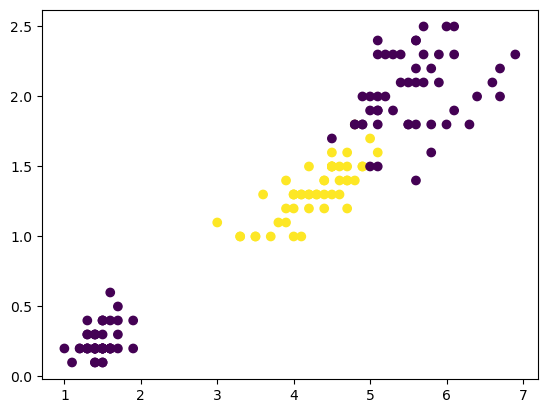

In [15]:
from sklearn import datasets

iris = datasets.load_iris()
X = iris["data"][:, (2,3)]
t = (iris["target"]==1).astype(int)

plt.scatter(X[:,0], X[:,1], c=t)


- 2 marks for implementation
- 2 marks for evaluation

Accuracy: 34.5


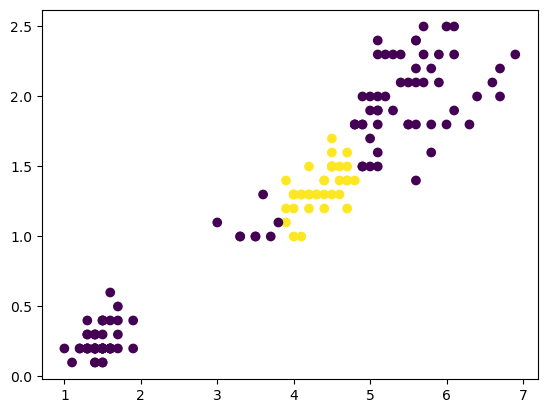

In [20]:
rng = np.random.RandomState(1)

#guassian rbf    
def rbf(x, centre, width):
    r = np.linalg.norm(x - centre)
    return np.exp(-(r/width)**2)
labels = fuzzy_c_means(X, 3, 12, 30, 1.2, 0.3)

centers = np.array([np.mean(X[labels == i], axis = 0) for i in np.unique(labels).astype(int)])
widths = np.array([np.mean(np.sqrt(np.sum((X[labels == i] - centers[np.unique(labels).astype(int) == i])**2, axis=1))) for i in np.unique(labels).astype(int)])
labels[labels == 0] = -1
weights = np.array([np.mean([labels[i] * np.linalg.norm(X[i] - centers[c]) for i in range(len(X))]) for c in np.unique(labels).astype(int)])

classifier = LogisticRegressionClassifier()
new_axis = [np.sum([rbf(x, centers[i], widths[i]) * weights[i] for i in range(len(centers))]) for x in X]
new_X = np.insert(X, 2, new_axis, axis=1)
classifier.train(new_X, t)

Y_pred = classifier.predict(new_X)
plt.scatter(X[:,0], X[:,1], c=Y_pred)

c_matrix = confusion_matrix(t, Y_pred)
print(f"Accuracy: {accuracy(c_matrix)}")